#### libraries

In [1]:
!git clone https://github.com/michelevece/vece-m5-forecasting-accuracy

Cloning into 'vece-m5-forecasting-accuracy'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 5), reused 18 (delta 3), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path_to_zip = './vece-m5-forecasting-accuracy/data/m5-forecasting-accuracy.zip'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall('./data/')

In [ ]:
#tr_ev = pd.read_csv('./data/sales_train_evaluation.csv')

In [4]:
import pylab
pylab.rcParams['figure.figsize'] = (12, 4)

## Data exploration

### Sell prices

In [5]:
prices = pd.read_csv('./data/sell_prices.csv')
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [6]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [7]:
prices['store_id'] = prices['store_id'].astype('category')
prices['item_id'] = prices['item_id'].astype('category')

prices['wm_yr_wk'] = prices['wm_yr_wk'].astype('int16')  
prices['sell_price'] = prices['sell_price'].astype('float16') 

In [8]:
print('Missing values:', prices.isna().any().any())

print('min week:', prices['wm_yr_wk'].min())
print('max week:', prices['wm_yr_wk'].max())

Missing values: False
min week: 11101
max week: 11621


Text(0.5, 1.0, 'Release week per each item/store')

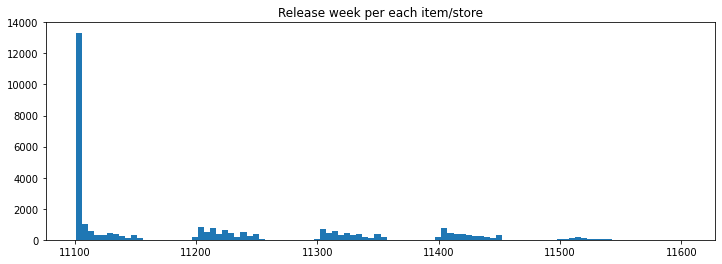

In [9]:
releases = prices.groupby(['store_id','item_id'])['wm_yr_wk'].min()#.hist(bins=100)
plt.hist(releases, bins=100)
plt.title('Release week per each item/store')

In [10]:
prices.groupby(['store_id','item_id'])['wm_yr_wk'].max().value_counts()

11621    30490
Name: wm_yr_wk, dtype: int64

In [11]:
prices.describe(include='category')

,store_id,item_id
count,6841121,6841121
unique,10,3049
top,TX_2,FOODS_3_586
freq,701214,2820


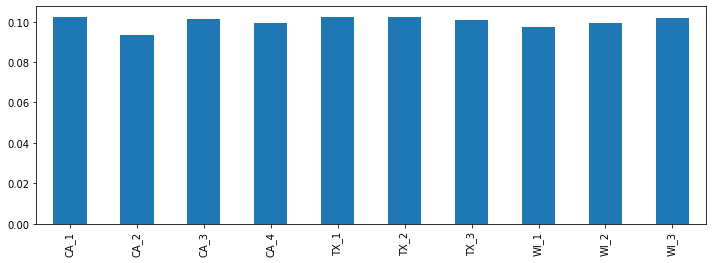

In [12]:
prices['store_id'].value_counts(normalize=True).sort_index().plot.bar()

### Calendar

In [13]:
calendar = pd.read_csv('./data/calendar.csv')
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [14]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


#### wday

In [15]:
# from saturday = 1, ..., friday = 7
# to monday = 1 ... sunday = 7
calendar['wday'] = (calendar['wday'] + 4) % 7 + 1

#### n_events

In [16]:
# number of events per day
n_events = 2 - calendar[['event_name_1', 'event_name_2']].isna().sum(axis=1)
calendar.insert(7, 'n_events', n_events)

del n_events

#### event_name: label encoding

In [17]:
# fill empty event records
calendar['event_name_1'].fillna('', inplace=True)
#calendar['event_type_1'].fillna('', inplace=True)
calendar['event_name_2'].fillna('', inplace=True)
#calendar['event_type_2'].fillna('', inplace=True)

In [18]:
# label encoding of the events
from sklearn.preprocessing import LabelEncoder

event_name_enc = LabelEncoder()
calendar['event_name_1'] = event_name_enc.fit_transform(calendar['event_name_1'])
calendar['event_name_2'] = event_name_enc.transform(calendar['event_name_2'])

#### event_type: one hot encoding

In [19]:
cols1 = pd.get_dummies(calendar['event_type_1']).astype('int8')
cols2 = pd.get_dummies(calendar['event_type_2']).astype('int8')
event_type = cols1.add(cols2, fill_value=0).astype('int8')
event_type

,Cultural,National,Religious,Sporting
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1964,0,0,0,0
1965,0,0,0,0
1966,0,0,0,0
1967,0,0,0,0


In [20]:
event_type.value_counts()

Cultural  National  Religious  Sporting
0         0         0          0           1807
                    1          0             53
          1         0          0             52
1         0         0          0             36
0         0         0          1             16
1         0         1          0              3
                    0          1              2
dtype: int64

In [21]:
calendar = pd.concat([calendar, event_type], axis=1) 
calendar.drop(columns=['event_type_1', 'event_type_2'], inplace=True)
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,n_events,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,Cultural,National,Religious,Sporting
0,2011-01-29,11101,Saturday,6,1,2011,d_1,0,0,0,0,0,0,0,0,0,0
1,2011-01-30,11101,Sunday,7,1,2011,d_2,0,0,0,0,0,0,0,0,0,0
2,2011-01-31,11101,Monday,1,1,2011,d_3,0,0,0,0,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,2,2,2011,d_4,0,0,0,1,1,0,0,0,0,0
4,2011-02-02,11101,Wednesday,3,2,2011,d_5,0,0,0,1,0,1,0,0,0,0


In [22]:
calendar_cols = calendar.columns.tolist()
ordered_cols = calendar_cols[:8] + calendar_cols[-4:] + calendar_cols[8:-4]
calendar = calendar[ordered_cols]
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,n_events,Cultural,National,Religious,Sporting,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,6,1,2011,d_1,0,0,0,0,0,0,0,0,0,0
1,2011-01-30,11101,Sunday,7,1,2011,d_2,0,0,0,0,0,0,0,0,0,0
2,2011-01-31,11101,Monday,1,1,2011,d_3,0,0,0,0,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,2,2,2011,d_4,0,0,0,0,0,0,0,1,1,0
4,2011-02-02,11101,Wednesday,3,2,2011,d_5,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,3,6,2016,d_1965,0,0,0,0,0,0,0,0,1,1
1965,2016-06-16,11620,Thursday,4,6,2016,d_1966,0,0,0,0,0,0,0,0,0,0
1966,2016-06-17,11620,Friday,5,6,2016,d_1967,0,0,0,0,0,0,0,0,0,0
1967,2016-06-18,11621,Saturday,6,6,2016,d_1968,0,0,0,0,0,0,0,0,0,0


In [ ]:
#calendar['is_weekend'] = (calendar['wday'] < 3).astype('int8')#.isin([1,2,7]).astype('int8')

#### new column: preholiday

In [23]:
bool_events = calendar['n_events'].astype('bool')

calendar['preholiday'] = 0

for i in range(10, 0, -1):
    calendar['preholiday'] = np.max([calendar['preholiday'], 
                                     (10-i+1) * bool_events.shift(-i).fillna(0).astype('int8')], axis=0)
    
calendar['preholiday'] = calendar['preholiday'].astype('int8')    

Text(0.5, 1.0, 'Preholiday and events')

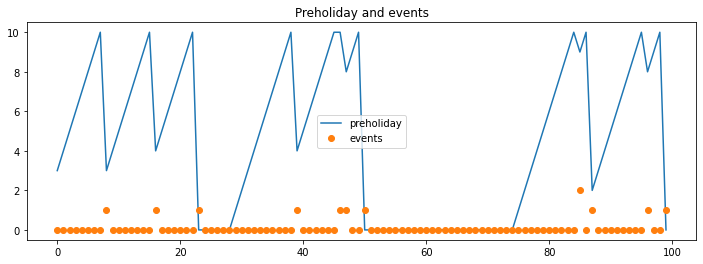

In [24]:
plt.plot(calendar['preholiday'][:100])
plt.plot(calendar['n_events'][:100], 'o')
plt.legend(['preholiday', 'events'])
plt.title('Preholiday and events')

#### casting

In [25]:
calendar['date'] = calendar['date'].astype('datetime64')

calendar['wm_yr_wk'] = calendar['wm_yr_wk'].astype('int16')#int8
calendar['wday'] = calendar['wday'].astype('int8')
calendar['month'] = calendar['month'].astype('int8')
calendar['year'] -= 2000
calendar['year'] = calendar['year'].astype('int8')
calendar['d'] = calendar['d'].apply(lambda x: x[2:]).astype('int16')

calendar['n_events'] = calendar['n_events'].astype('int8')

calendar['event_name_1'] = calendar['event_name_1'].astype('int8')
#calendar['event_type_1'] = calendar['event_type_1'].astype('int8')
calendar['event_name_2'] = calendar['event_name_2'].astype('int8')
#calendar['event_type_2'] = calendar['event_type_2'].astype('int8')

calendar['snap_CA'] = calendar['snap_CA'].astype('int8')
calendar['snap_TX'] = calendar['snap_TX'].astype('int8')
calendar['snap_WI'] = calendar['snap_WI'].astype('int8')

In [26]:
calendar.insert(4, 'day', calendar['date'].apply(lambda x: x.day)) 
calendar['day'] = calendar['day'].astype('int8')

In [ ]:
'''
weekdays = pd.get_dummies(calendar['weekday'], prefix='wday').astype('int8')
calendar = pd.concat([calendar, weekdays], axis=1)

months = pd.get_dummies(calendar['month'], prefix='month').astype('int8')
calendar = pd.concat([calendar, months], axis=1)
'''

In [27]:
#weekdays = pd.get_dummies(calendar['weekday'], prefix='wday').astype('int8')
#calendar = pd.concat([calendar, weekdays], axis=1)
calendar.drop(columns='weekday', inplace=True)

In [28]:
calendar.set_index('d', inplace=True)

In [29]:
calendar.head()

,date,wm_yr_wk,wday,day,month,year,n_events,Cultural,National,Religious,Sporting,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,preholiday
d,,,,,,,,,,,,,,,,,
1,2011-01-29,11101,6,29,1,11,0,0,0,0,0,0,0,0,0,0,3
2,2011-01-30,11101,7,30,1,11,0,0,0,0,0,0,0,0,0,0,4
3,2011-01-31,11101,1,31,1,11,0,0,0,0,0,0,0,0,0,0,5
4,2011-02-01,11101,2,1,2,11,0,0,0,0,0,0,0,1,1,0,6
5,2011-02-02,11101,3,2,2,11,0,0,0,0,0,0,0,1,0,1,7


In [30]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 1 to 1969
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   wday          1969 non-null   int8          
 3   day           1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int8          
 6   n_events      1969 non-null   int8          
 7   Cultural      1969 non-null   int8          
 8   National      1969 non-null   int8          
 9   Religious     1969 non-null   int8          
 10  Sporting      1969 non-null   int8          
 11  event_name_1  1969 non-null   int8          
 12  event_name_2  1969 non-null   int8          
 13  snap_CA       1969 non-null   int8          
 14  snap_TX       1969 non-null   int8          
 15  snap_WI       1969 non-null   int8    

In [31]:
# check no missing values in the 'date' column
(calendar['date'][1:].reset_index(drop=True) - calendar['date'][:-1]).value_counts()

2 days    1967
Name: date, dtype: int64

In [32]:
print('date min:', calendar['date'].min().date())
print('date max:', calendar['date'].max().date())

date min: 2011-01-29
date max: 2016-06-19


### train_validation

In [33]:
tr_val = pd.read_csv('./data/sales_train_validation.csv')
tr_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [34]:
tr_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [35]:
tr_val.drop(columns='id', inplace=True)

In [36]:
# rename day columns by deleting 'd_'
tr_val.rename(columns={x: x[2:] for x in tr_val.columns[5:]}, inplace=True)

In [37]:
tr_val.head()

,item_id,dept_id,cat_id,store_id,state_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


#### casting

In [ ]:
#cat_cols = tr_val.columns.tolist()[:5]
#tr_val[cat_cols] = tr_val[cat_cols].astype('category')

#int_cols = tr_val.columns.tolist()[5:]
#for c in int_cols:
#    tr_val[c] = tr_val[c].astype('int16')

### Data exploration

Text(0.5, 1.0, 'Sales (records) per state')

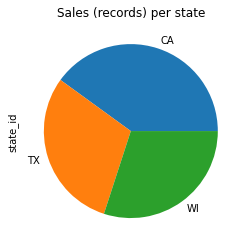

In [38]:
tr_val['state_id'].value_counts().plot.pie()
plt.title('Sales (records) per state')

Text(0.5, 1.0, 'sales (records) per store')

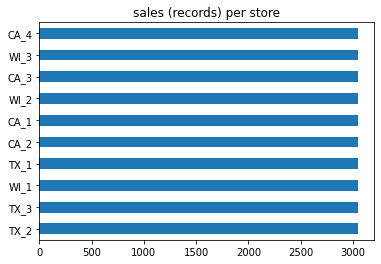

In [39]:
tr_val['store_id'].value_counts().plot.barh(figsize=(6,4))
plt.title('sales (records) per store')

Text(0.5, 1.0, 'sales per category')

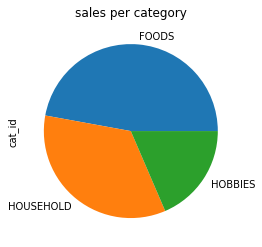

In [40]:
tr_val['cat_id'].value_counts().plot.pie() #hist()
plt.title('sales per category')

Text(0.5, 1.0, 'sales per department')

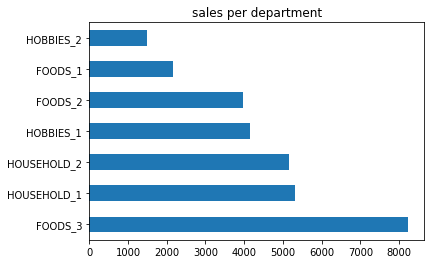

In [41]:
tr_val['dept_id'].value_counts().plot.barh(figsize=(6,4)) #hist(bins= 7)
plt.title('sales per department')

#### categories: plot

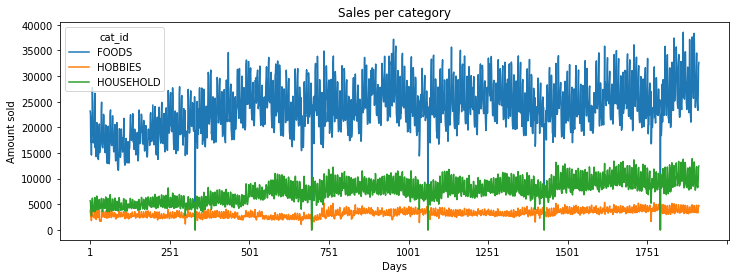

In [42]:
tr_val.groupby('cat_id')[tr_val.columns[5:]].sum().transpose().plot()
plt.title('Sales per category')
plt.xlabel('Days')
plt.ylabel('Amount sold')
plt.show()

In [44]:
def plot_category(c):
    data = tr_val[tr_val['cat_id']==c].reset_index(drop=True)
    data.groupby('dept_id')[data.columns[5:]].sum().transpose().plot()
    plt.legend()
    plt.title(f'Sales per {c}')
    plt.xlabel('Days')
    plt.ylabel('Amount sold')
    plt.show()

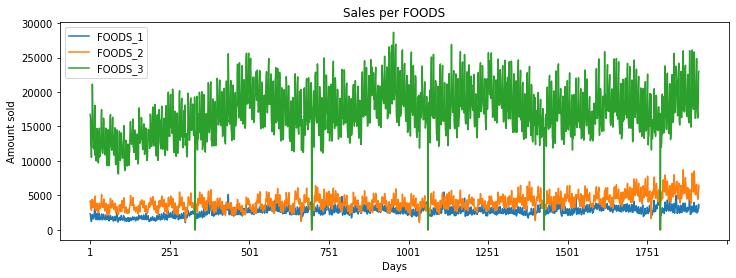

In [45]:
plot_category('FOODS')

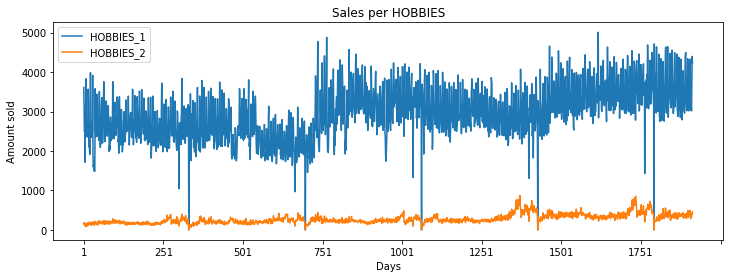

In [46]:
plot_category('HOBBIES')

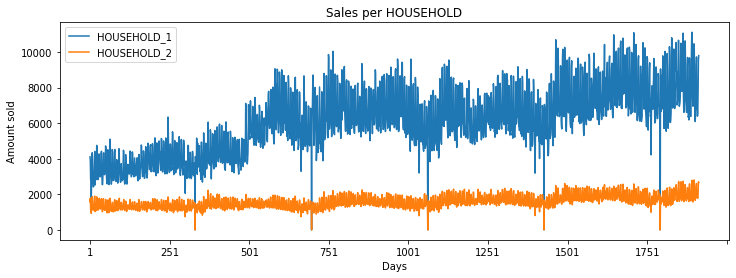

In [47]:
plot_category('HOUSEHOLD')

#### departments: plot

In [48]:
def plot_departments(d, a=0.75):
    data = tr_val[tr_val['dept_id']==d].reset_index(drop=True)
    data.groupby('state_id')[data.columns[5:]].sum().transpose().plot(alpha=a)
    plt.legend()
    plt.title(f'Sales per {d}')
    plt.xlabel('Days')
    plt.ylabel('Amount sold')
    plt.show()

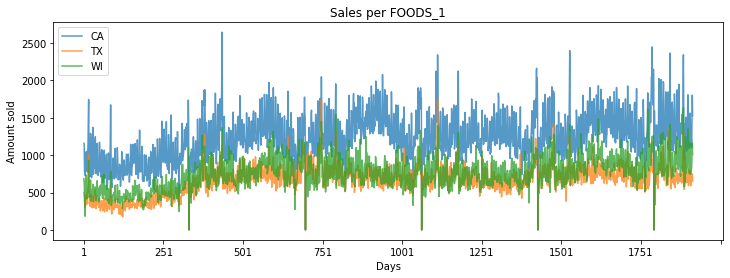

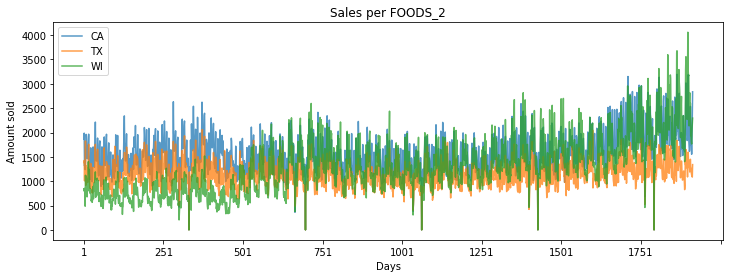

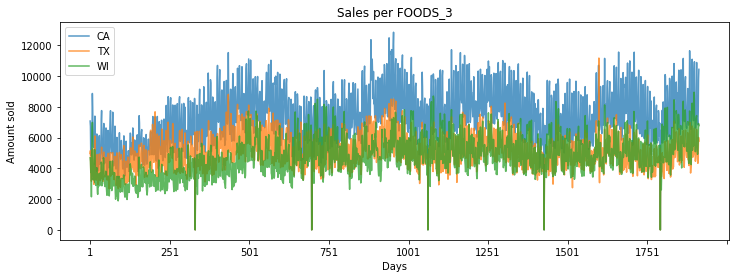

In [49]:
plot_departments('FOODS_1')
plot_departments('FOODS_2')
plot_departments('FOODS_3')

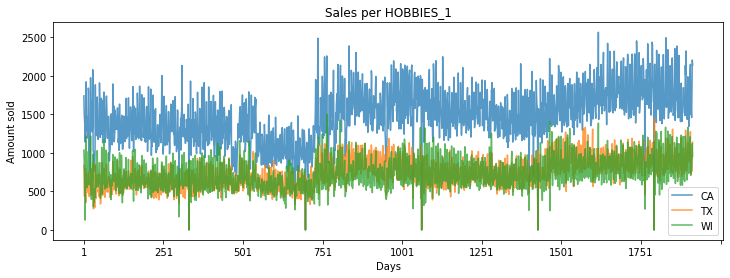

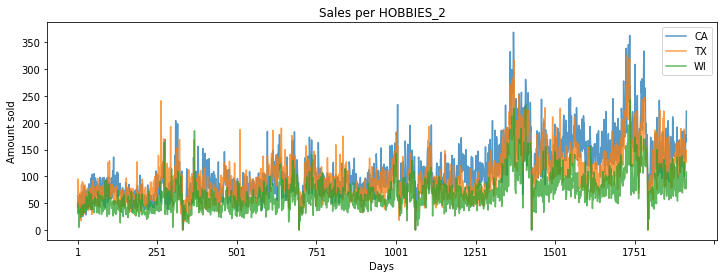

In [50]:
plot_departments('HOBBIES_1')
plot_departments('HOBBIES_2')

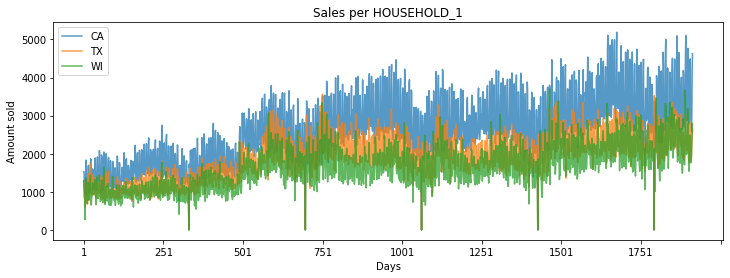

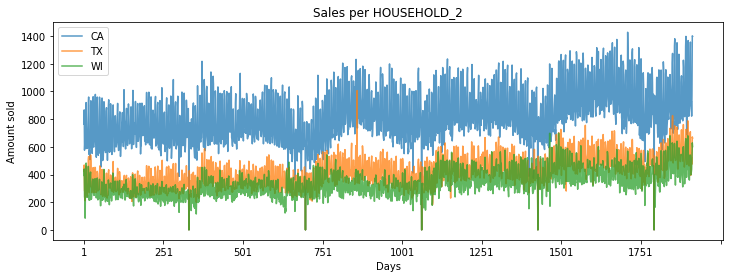

In [51]:
plot_departments('HOUSEHOLD_1')
plot_departments('HOUSEHOLD_2')

#### sales per date

In [52]:
calendar2 = calendar.set_index('date', drop=True, inplace=False)

In [53]:
def get_sales_per_date(d, stop=1913):
    #sales_per_date = pd.DataFrame(tr_val.loc[tr_val['dept_id']==d, tr_val.columns[5:]].sum(), columns=['sales'])
    sales_per_date = tr_val.loc[tr_val['dept_id']==d, tr_val.columns[4:]].groupby('state_id').sum().transpose()#pd.DataFrame(tr_val.loc[tr_val['dept_id']==d, tr_val.columns[4:]].groupby('state_id').sum(), columns=['sales'])
    #sales_per_date = tr_val.loc[tr_val['dept_id']==d, tr_val.columns[4:]].groupby('state_id').sum().transpose()#pd.DataFrame(tr_val.loc[tr_val['dept_id']==d, tr_val.columns[4:]].groupby('state_id').sum(), columns=['sales'])
    sales_per_date.index = calendar['date'][:stop]
    sales_per_date = sales_per_date.join(calendar2)
    return sales_per_date

In [54]:
depts = tr_val['dept_id'].unique()

sales_date = [get_sales_per_date(d) for d in depts]

#### SNAP days

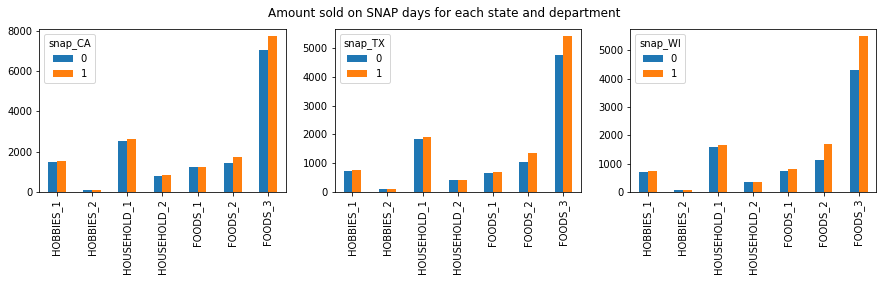

In [55]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
fig.suptitle('Amount sold on SNAP days for each state and department')
for i, state in enumerate(tr_val['state_id'].unique()):
    data = pd.DataFrame([s.groupby(f'snap_{state}')[state].mean() for s in sales_date])
    data.index = depts
    data.plot.bar(ax=ax[i])
del data    

On average, on SNAP days sales are slightly higher.

#### Looking for patterns/seasonality

In [56]:
def plot_dmy_departments(i, loc=4):
    d = depts[i]

    fig, ax = plt.subplots(2, 3, figsize=(16, 8))
    fig.suptitle(f'Sales per {d}')
    axs = ax.ravel()

    cur_ax = axs[0]
    sales_date[i].groupby('wday')[['CA', 'TX', 'WI']].mean().plot(ax=cur_ax)#groupby('wday')['sales'].mean().sort_index().plot(ax=cur_ax, kind='bar')
    cur_ax.set_xlabel('Days of the week')
    cur_ax.set_ylabel('Amount sold')
    cur_ax.legend(loc=loc)

    cur_ax = axs[1]
    sales_date[i].groupby('month')[['CA', 'TX', 'WI']].mean().plot(ax=cur_ax)
    cur_ax.set_xlabel('Months')
    cur_ax.set_ylabel('Amount sold')
    cur_ax.legend(loc=loc)

    cur_ax = axs[2]
    sales_date[i].groupby('day')[['CA', 'TX', 'WI']].mean().plot(ax=cur_ax)
    cur_ax.set_xlabel('Days of the month')
    cur_ax.set_ylabel('Amount sold')
    cur_ax.legend(loc=loc)

    cur_ax = axs[3]
    sales_date[i].groupby(['year','month'])['CA'].mean().unstack(0).plot(ax=cur_ax)
    cur_ax.set_xlabel('Months')
    cur_ax.set_ylabel('Amount sold in CA')
    cur_ax.legend(loc=loc)

    cur_ax = axs[4]
    sales_date[i].groupby(['year','month'])['TX'].mean().unstack(0).plot(ax=cur_ax)
    cur_ax.set_xlabel('Months')
    cur_ax.set_ylabel('Amount sold in TX')
    cur_ax.legend(loc=loc)

    cur_ax = axs[5]
    sales_date[i].groupby(['year','month'])['WI'].mean().unstack(0).plot(ax=cur_ax)
    cur_ax.set_xlabel('Months')
    cur_ax.set_ylabel('Amount sold in WI')
    cur_ax.legend(loc=loc)

* All the departments have higher sales during the weekends
* Sales vary according to the month and the day of the year
* Sales increased over the years



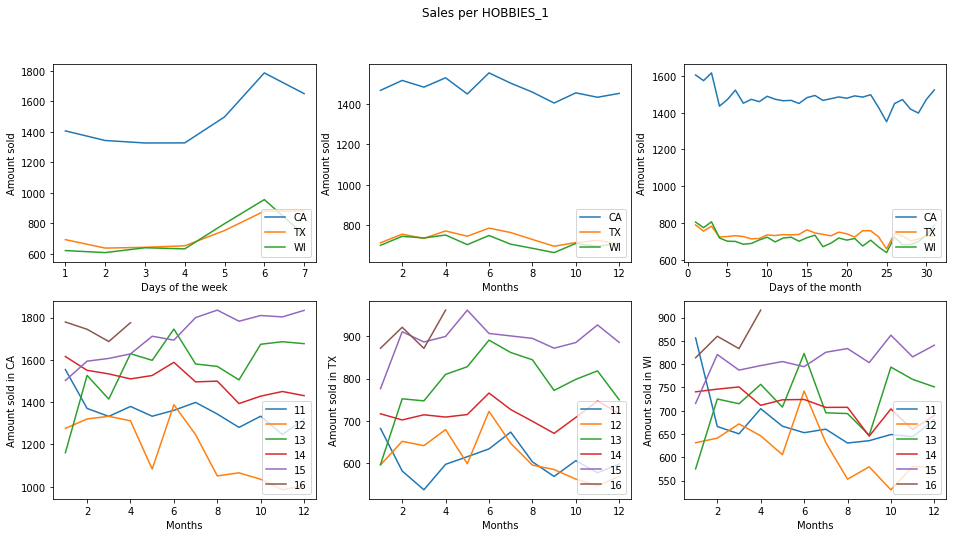

In [57]:
plot_dmy_departments(0)

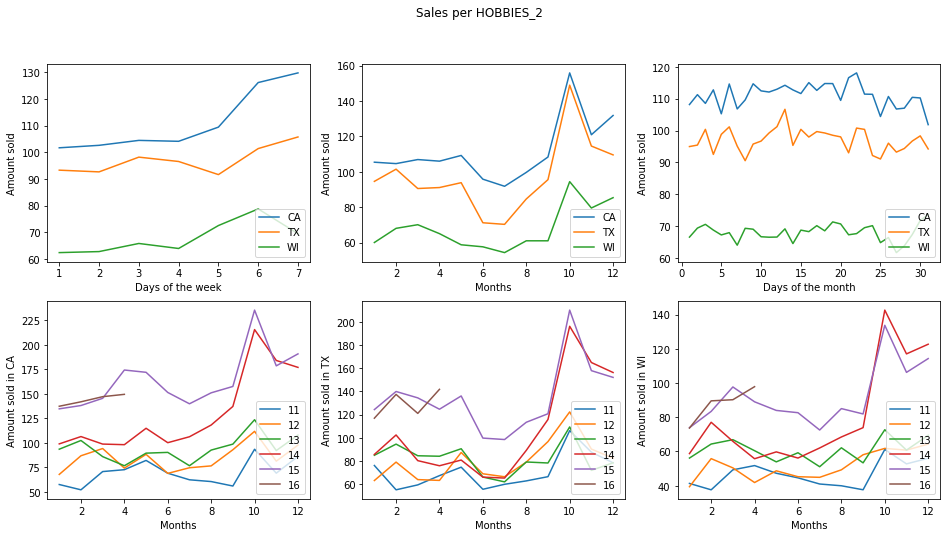

In [58]:
plot_dmy_departments(1)

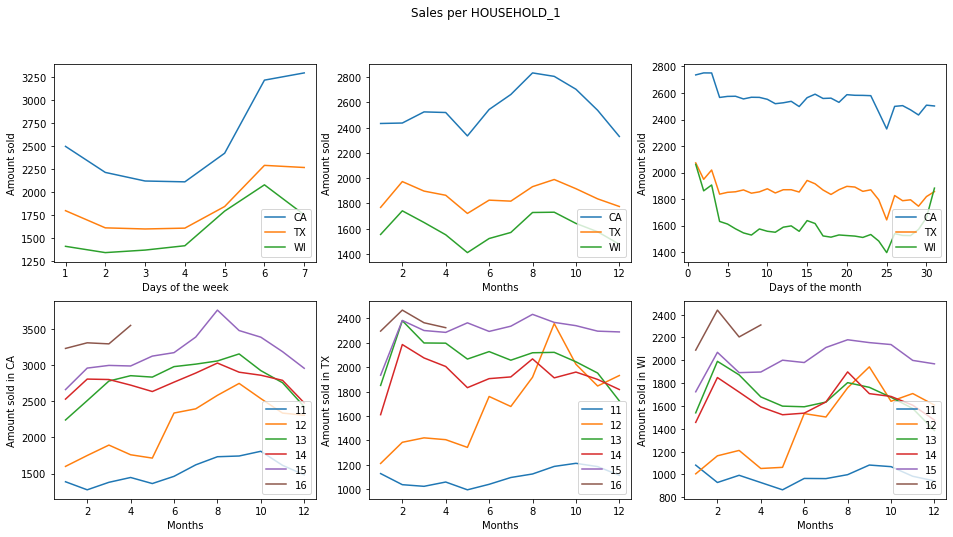

In [59]:
plot_dmy_departments(2)

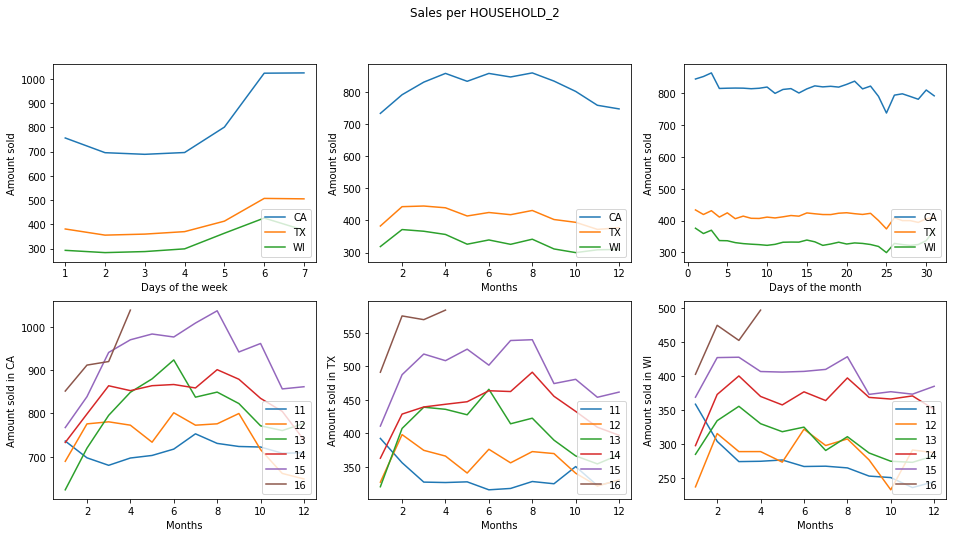

In [60]:
plot_dmy_departments(3)

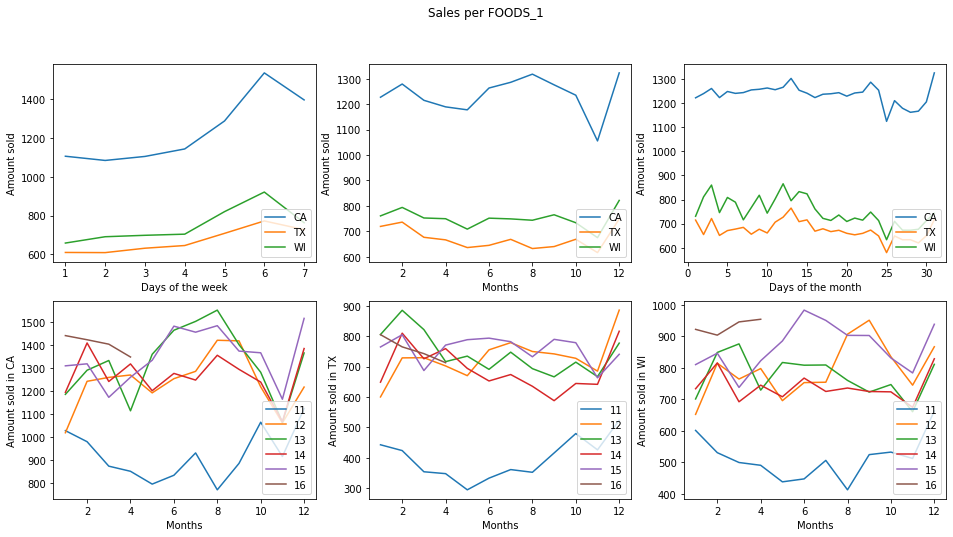

In [61]:
plot_dmy_departments(4)

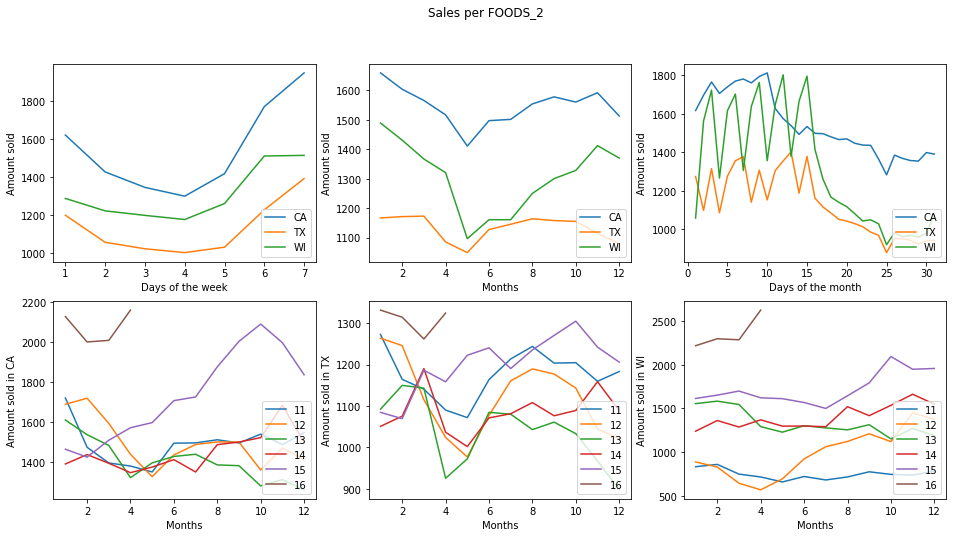

In [62]:
plot_dmy_departments(5)

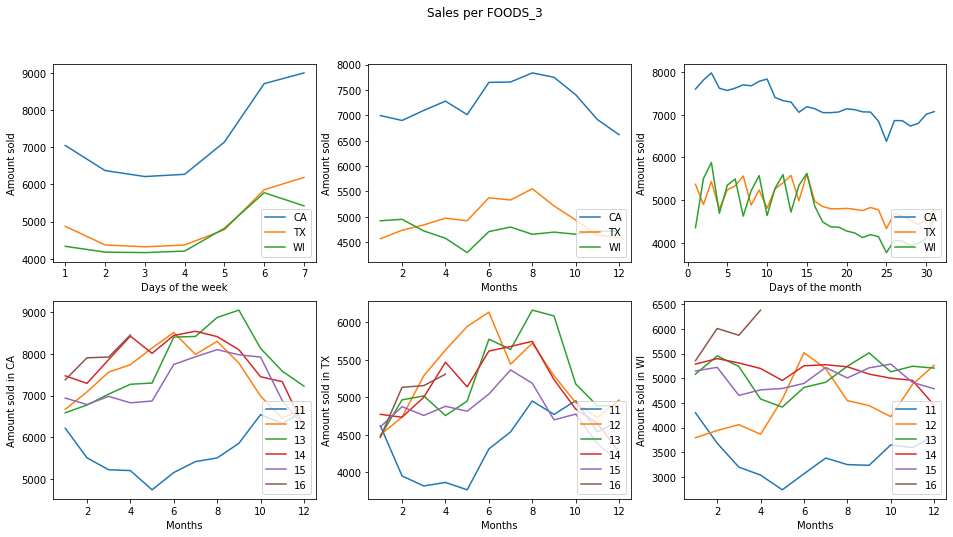

In [63]:
plot_dmy_departments(6)

### seasonality, stationarity

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(0.0, 365.0)

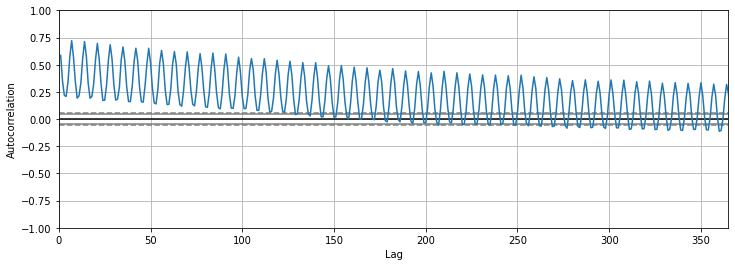

In [74]:
pd.plotting.autocorrelation_plot(sales_date[0]['TX']).set_xlim([0, 365])

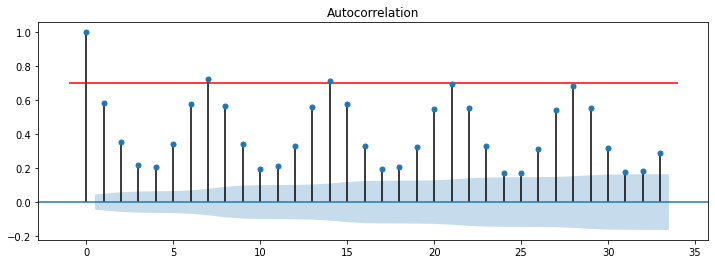

In [66]:
plot_acf(sales_date[0]['TX']).show()
plt.hlines(0.7, -1, 34, 'red') #line(0.7)

In [67]:
from statsmodels.tsa.stattools import adfuller, kpss

In [68]:
stationary_pvalue = adfuller(sales_date[0]['TX'].values)[1]
print(f'p-value for stationarity: {stationary_pvalue:.2f}')

p-value for stationarity: 0.38


In [69]:
sales_diff_28 = sales_date[0]['TX'].diff(28).dropna()
stationary_pvalue = adfuller(sales_diff_28.values)[1]
print(f'p-value for stationarity: {stationary_pvalue:.2f}')

p-value for stationarity: 0.00


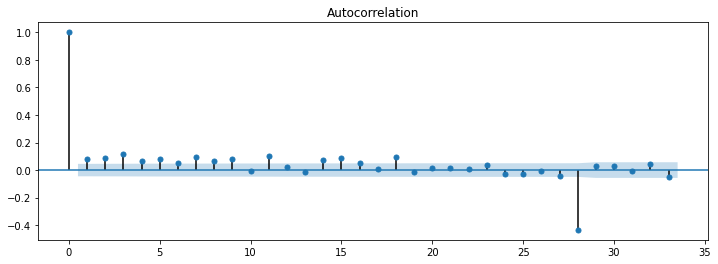

In [70]:
plot_acf(sales_diff_28).show()

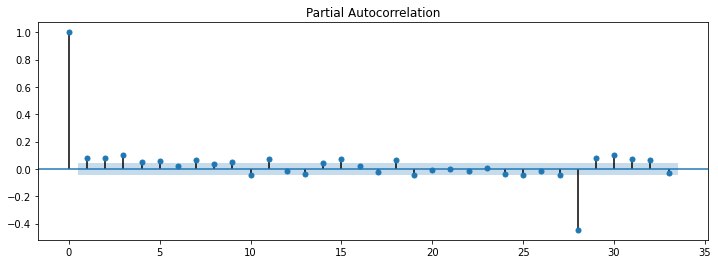

In [71]:
plot_pacf(sales_diff_28).show()

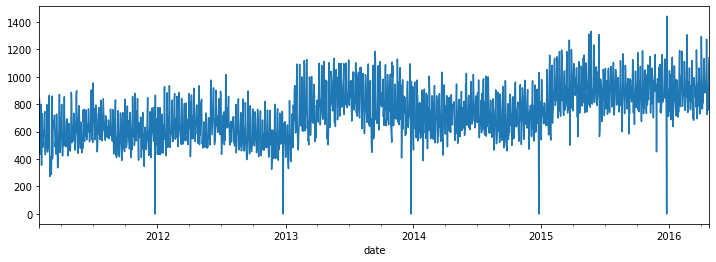

In [72]:
sales_date[0]['TX'].plot()

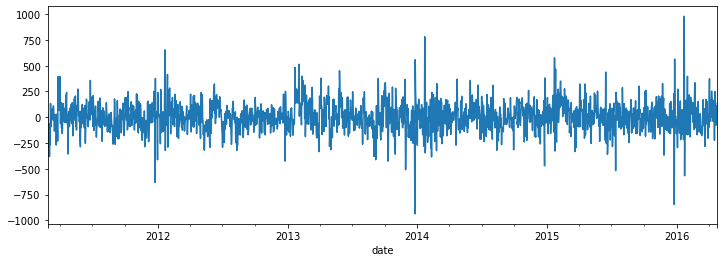

In [73]:
sales_diff_28.plot()

### dataset

In [ ]:
sales = tr_val[tr_val['dept_id'] =='HOUSEHOLD_1']
#sales = tr_val[tr_val['store_id'] =='CA_1']

In [ ]:
sales.reset_index(drop=True, inplace=True)

In [ ]:
sales.head()

,item_id,dept_id,cat_id,store_id,state_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913
0,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,3,0,0,0,0,0,0,1,0,0,2,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,2,1,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1
1,HOUSEHOLD_1_002,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,1,2,4,1,0,0,1,0,0,0,0,0,3,2,2,0,3,2,0,0,3,1,0,0,1,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,HOUSEHOLD_1_003,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5,1,1,1,1,1,2,2,2,1,0,2,0,0,0,2,1,0,1,0,1,0,1,0,1,2,3,0,0,1,2,1,0,0,0,1,0
3,HOUSEHOLD_1_004,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,4,0,8,11,1,0,3,8,6,4,1,6,3,3,0,3,6,4,2,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,5,2,0,0,1,3,1,0,3,0,0,0,0,1,6,1,6,1,1,0,1,1,7,0,2,0,0,1,0,5,0,0,0,0,0,0,1,0
4,HOUSEHOLD_1_005,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,0,3,2,2,1,2,1,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,5,1,2,2,1,3,3,0,2,1,0,1,1,1,1,2,0,2,3,1,3,5,1,1,2,1,1,0,3,1,2,0,0,1,0,1


### sales + calendar

In [ ]:
df = sales.melt(id_vars=sales.columns[:5].tolist(), var_name='d', value_name='demand')

df['d'] = df['d'].astype('int16')
df['demand'] = df['demand'].astype('int16')

df.dtypes

item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
d            int16
demand       int16
dtype: object

In [ ]:
df = pd.merge(df, calendar, left_on='d', right_index=True, how='left')

In [ ]:
#df = df[df['year']>12]
df.reset_index(inplace=True, drop=True)

##### deal with snaps

In [ ]:
# keep only the snap corresponding to the state of each record
df.insert(df.shape[1], 'snap', 0)
df['snap'] = df['snap'].astype('int8')

idx = df['state_id'] == 'CA'
df.loc[idx, 'snap'] = df['snap_CA'][idx]

idx = df['state_id'] == 'TX'
df.loc[idx, 'snap'] = df['snap_TX'][idx]

idx = df['state_id'] == 'WI'
df.loc[idx, 'snap'] = df['snap_WI'][idx]

df.drop(columns=['snap_CA', 'snap_TX', 'snap_WI'], inplace=True)

In [ ]:
df.sort_values(['item_id', 'store_id', 'd'], inplace=True)

In [ ]:
df.reset_index(inplace=True, drop=True)

### fe: prices

assumption we know the prices at the moment of the prediction

In [ ]:
df = pd.merge(df, prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
df.reset_index(inplace=True, drop=True)

In [ ]:
df['price_last_week'] = df.groupby(['item_id', 'store_id'])['sell_price'].shift(7).astype('float16')
df['price_last_week'] = df['sell_price'] / df['price_last_week']
df['price_last_week'] -= 1 

In [ ]:
df['price_curr_month'] = df.groupby(['item_id', 'store_id', 'month'])['sell_price'] \
                           .transform('mean').astype('float16')
df['price_curr_month'] = df['sell_price'] / df['price_curr_month']
df['price_curr_month'] -= 1

df['price_curr_year'] = df.groupby(['item_id', 'store_id', 'year'])['sell_price'] \
                           .transform('mean').astype('float16') 
df['price_curr_year'] = df['sell_price'] / df['price_curr_year']                           
df['price_curr_year'] -= 1

#####  same store, similar product

In [ ]:
# in realta gia facciamo lo same dept.. quindi magari lasciare solo store e wmyrwk
df['price_curr_week_same_dept'] = df.groupby(['store_id', 'wm_yr_wk'])['sell_price'] \
                                 .transform('mean').astype('float16')
df['price_curr_week_same_dept'] = df['sell_price'] / df['price_curr_week_same_dept']                                
df['price_curr_week_same_dept'] -= 1

In [ ]:
df.head()

,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,day,month,year,n_events,Cultural,National,Religious,Sporting,event_name_1,event_name_2,preholiday,snap,sell_price,price_last_week,price_curr_month,price_curr_year,price_curr_week_same_dept
0,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,3,2011-01-29,11101,6,29,1,11,0,0,0,0,0,0,0,3,0,6.320312,NaN,0.024414,-0.043945,0.287109
1,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,2,0,2011-01-30,11101,7,30,1,11,0,0,0,0,0,0,0,4,0,6.320312,NaN,0.024414,-0.043945,0.287109
2,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,3,0,2011-01-31,11101,1,31,1,11,0,0,0,0,0,0,0,5,0,6.320312,NaN,0.024414,-0.043945,0.287109
3,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,4,0,2011-02-01,11101,2,1,2,11,0,0,0,0,0,0,0,6,1,6.320312,NaN,0.045898,-0.043945,0.287109
4,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,5,0,2011-02-02,11101,3,2,2,11,0,0,0,0,0,0,0,7,1,6.320312,NaN,0.045898,-0.043945,0.287109


#### prices: mean, min, max

In [ ]:
df['price_mean'] = df.groupby(['store_id', 'item_id'])['sell_price'].transform('mean').astype('float16')
df['price_min'] = df.groupby(['store_id', 'item_id'])['sell_price'].transform('min').astype('float16')
df['price_max'] = df.groupby(['store_id', 'item_id'])['sell_price'].transform('max').astype('float16')
df['price_std'] = df.groupby(['store_id', 'item_id'])['sell_price'].transform('std').astype('float16')

In [ ]:
df['price_mean'] = df['sell_price'] / df['price_mean']
df['price_mean'] -= 1

df['price_min'] = df['sell_price'] / df['price_min']
df['price_max'] = df['sell_price'] / df['price_max']

### fe: demand

#### lag 

In [ ]:
SHIFT = 28

for r in range(4):
    lag = 7*r
    df[f'demand_{SHIFT}_{lag}'] = df.groupby(['item_id', 'store_id'])['demand'] \
                                    .shift(SHIFT+lag).astype('float16')

cols = [f'demand_{SHIFT}_{7*lag}' for lag in range(4)]

df['demand_28_avg'] = df[cols].mean(axis=1)

In [ ]:
print(df[cols].corrwith(df['demand']))
print(df[['demand_28_avg']].corrwith(df['demand']))

demand_28_0     0.594833
demand_28_7     0.582345
demand_28_14    0.576658
demand_28_21    0.567676
dtype: float64
demand_28_avg    0.686912
dtype: float64


In [ ]:
df = df.drop(columns=cols)
del cols

#### rolling mean

In [ ]:
# average on the same day, over the last 12 months 
df['demand_same_d'] = df.groupby(['item_id', 'store_id', 'day'])['demand'] \
                        .shift().rolling(12).mean().astype('float16')

In [ ]:
# average on the same month, over almost one month (=28 days)
# shifted by 28 to ensure no leak value
df['demand_same_m'] = df.groupby(['item_id', 'store_id', 'month'])['demand'] \
                        .shift(28).rolling(28).mean().astype('float16')

In [ ]:
## average on same day and month, over the last 3 years
df['demand_same_md'] = df.groupby(['item_id', 'store_id', 'month', 'day'])['demand']\
                         .shift().rolling(3).mean().astype('float16')

In [ ]:
df[['demand_same_d', 'demand_same_m', 'demand_same_md']].corrwith(df['demand'])

demand_same_d     0.689531
demand_same_m     0.556498
demand_same_md    0.471095
dtype: float64

In [ ]:
# rolling mean over 28 days, 
# shifted by 28 days to ensure no leakage
r = 28
df[f'rolling_mean_{SHIFT}_{r}'] = df.groupby(['item_id', 'store_id'])['demand'] \
                                    .shift(SHIFT).rolling(r).mean().astype('float16')

In [ ]:
##for r in [7, 14, 21, 28]: #, 60, 180, 365]:
##    df[f'rolling_mean_{SHIFT}_{r}'] = df.groupby(['item_id', 'store_id'])['demand'] \
##                                        .shift(SHIFT).rolling(r).mean().astype('float16')                           
  

In [ ]:
df.corrwith(df['demand'])

d                            0.088936
demand                       1.000000
wm_yr_wk                     0.089680
wday                         0.051842
day                         -0.011409
month                        0.002909
year                         0.087387
n_events                    -0.008988
Cultural                    -0.002851
National                    -0.010431
Religious                   -0.002084
Sporting                    -0.001331
event_name_1                -0.006025
event_name_2                -0.000570
preholiday                   0.002140
snap                         0.007257
sell_price                  -0.195451
price_last_week             -0.000532
price_curr_month            -0.010958
price_curr_year              0.000048
price_curr_week_same_dept   -0.194885
price_mean                  -0.010949
price_min                   -0.010274
price_max                   -0.000825
price_std                   -0.067251
demand_28_avg                0.686912
demand_same_

In [ ]:
#SHIFT2=1
##for shift_2 in [1, 7, 14, 21]:
##    for r in [7, 14, 21, 28]:
##        df[f'rolling_mean_{shift_2}_{r}'] = df.groupby(['store_id', 'item_id'])['demand'] \
##                                              .shift(shift_2).rolling(r).mean().astype('float16')

In [ ]:
df.head()

,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,day,month,year,n_events,Cultural,National,Religious,Sporting,event_name_1,event_name_2,preholiday,snap,sell_price,price_last_week,price_curr_month,price_curr_year,price_curr_week_same_dept,price_mean,price_min,price_max,price_std,demand_28_avg,demand_same_d,demand_same_m,demand_same_md,rolling_mean_28_28
0,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,1,3,2011-01-29,11101,6,29,1,11,0,0,0,0,0,0,0,3,0,6.320312,NaN,0.024414,-0.043945,0.287109,0.036133,1.058594,0.906738,0.306885,NaN,NaN,NaN,NaN,NaN
1,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,2,0,2011-01-30,11101,7,30,1,11,0,0,0,0,0,0,0,4,0,6.320312,NaN,0.024414,-0.043945,0.287109,0.036133,1.058594,0.906738,0.306885,NaN,NaN,NaN,NaN,NaN
2,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,3,0,2011-01-31,11101,1,31,1,11,0,0,0,0,0,0,0,5,0,6.320312,NaN,0.024414,-0.043945,0.287109,0.036133,1.058594,0.906738,0.306885,NaN,NaN,NaN,NaN,NaN
3,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,4,0,2011-02-01,11101,2,1,2,11,0,0,0,0,0,0,0,6,1,6.320312,NaN,0.045898,-0.043945,0.287109,0.036133,1.058594,0.906738,0.306885,NaN,NaN,NaN,NaN,NaN
4,HOUSEHOLD_1_001,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,5,0,2011-02-02,11101,3,2,2,11,0,0,0,0,0,0,0,7,1,6.320312,NaN,0.045898,-0.043945,0.287109,0.036133,1.058594,0.906738,0.306885,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10177160 entries, 0 to 10177159
Data columns (total 36 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   item_id                    object        
 1   dept_id                    object        
 2   cat_id                     object        
 3   store_id                   object        
 4   state_id                   object        
 5   d                          int16         
 6   demand                     int16         
 7   date                       datetime64[ns]
 8   wm_yr_wk                   int16         
 9   wday                       int8          
 10  day                        int8          
 11  month                      int8          
 12  year                       int8          
 13  n_events                   int8          
 14  Cultural                   int8          
 15  National                   int8          
 16  Religious                  int8   

In [ ]:
df.memory_usage()

Index                             128
item_id                      22802960
dept_id                      22802960
cat_id                       22802960
store_id                     22802960
state_id                     22802960
d                             5700740
demand                        5700740
date                         22802960
wm_yr_wk                      5700740
wday                          2850370
day                           2850370
month                         2850370
year                          2850370
n_events                      2850370
Cultural                      2850370
National                      2850370
Religious                     2850370
Sporting                      2850370
event_name_1                  2850370
event_name_2                  2850370
preholiday                    2850370
snap                          2850370
sell_price                    5700740
price_lag_7d                  5700740
price_curr_month              5700740
price_curr_y

In [ ]:
'''
groupby = [['state_id'], ['store_id'], ['cat_id'], ['dept_id'], ['item_id'],
           ['state_id', 'cat_id'],
           ['state_id', 'dept_id'],
           ['state_id', 'item_id'],
           ['store_id', 'cat_id'],
           ['store_id', 'dept_id'],
           ['store_id', 'item_id']]

for c in groupby:
    s = 'demand_' + '_'.join(c)
    df[s] = df.groupby(c)['demand'].transform('mean').astype('float16')           
'''    

In [ ]:
import gc
gc.collect()

197

### nan

In [ ]:
flag = df.isna().any().any()

print('there are nan? ', flag)

if flag:
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)

there are nan?  True


In [ ]:
df.corrwith(df['demand'])

d                           -0.023861
demand                       1.000000
wm_yr_wk                    -0.021864
wday                         0.060077
day                         -0.014075
month                       -0.001714
year                        -0.022340
n_events                    -0.009338
Cultural                    -0.001204
National                    -0.012869
Religious                   -0.001812
Sporting                    -0.000984
event_name_1                -0.005573
event_name_2                -0.001992
preholiday                   0.004989
snap                         0.009349
sell_price                  -0.197137
price_last_week             -0.000542
price_curr_month            -0.008960
price_curr_year              0.001191
price_curr_week_same_dept   -0.196727
price_mean                  -0.009014
price_min                   -0.010305
price_max                   -0.004849
price_std                   -0.104549
demand_28_avg                0.673848
demand_same_

### categories

In [ ]:
#df = pd.concat([df, pd.get_dummies(df['state_id'])], axis=1)

In [ ]:
#df = pd.concat([df, pd.get_dummies(df['store_id'])], axis=1)

In [ ]:
#df = pd.concat([df, pd.get_dummies(df['month'])], axis=1)

In [ ]:
#df = pd.concat([df, pd.get_dummies(df['wday'])], axis=1)

In [ ]:
df.head()

,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,day,month,year,n_events,Cultural,National,Religious,Sporting,event_name_1,event_name_2,preholiday,snap,sell_price,price_lag_7d,price_curr_month,price_curr_year,price_last_week,price_curr_week_same_dept,price_mean,price_min,price_max,price_std,demand_28_avg,demand_same_d,demand_same_m,demand_same_md,rolling_mean_28_28,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
0,HOBBIES_2_001,HOBBIES_2,HOBBIES,CA_1,CA,390,0,2012-02-22,11204,3,22,2,12,1,0,0,1,0,12,0,4,0,5.671875,0.0,0.000977,-0.025391,0.0,0.969727,0.00293,1.037109,0.950195,0.230225,0.00,0.000000,0.142822,0.666504,0.071411,1,0,0,1,0,0,0,0,0,0,0,0,0
1,HOBBIES_2_001,HOBBIES_2,HOBBIES,CA_1,CA,391,0,2012-02-23,11204,4,23,2,12,0,0,0,0,0,0,0,5,0,5.671875,0.0,0.000977,-0.025391,0.0,0.969727,0.00293,1.037109,0.950195,0.230225,0.00,0.000000,0.107117,0.666504,0.071411,1,0,0,1,0,0,0,0,0,0,0,0,0
2,HOBBIES_2_001,HOBBIES_2,HOBBIES,CA_1,CA,392,0,2012-02-24,11204,5,24,2,12,0,0,0,0,0,0,0,6,0,5.671875,0.0,0.000977,-0.025391,0.0,0.969727,0.00293,1.037109,0.950195,0.230225,0.00,0.083313,0.107117,0.000000,0.071411,1,0,0,1,0,0,0,0,0,0,0,0,0
3,HOBBIES_2_001,HOBBIES_2,HOBBIES,CA_1,CA,393,1,2012-02-25,11205,6,25,2,12,0,0,0,0,0,0,0,7,0,5.671875,0.0,0.000977,-0.025391,0.0,0.969727,0.00293,1.037109,0.950195,0.230225,0.00,0.083313,0.142822,0.333252,0.071411,1,0,0,1,0,0,0,0,0,0,0,0,0
4,HOBBIES_2_001,HOBBIES_2,HOBBIES,CA_1,CA,394,1,2012-02-26,11205,7,26,2,12,0,0,0,0,0,0,0,8,0,5.671875,0.0,0.000977,-0.025391,0.0,0.969727,0.00293,1.037109,0.950195,0.230225,0.25,0.083313,0.178589,0.666504,0.071411,1,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# categories

for c in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    df[c] = df[c].astype('category')

cat_dic = dict()

for c in df.select_dtypes('category').columns.to_list():
    cat_dic[c] = dict(enumerate(df[c].cat.categories))

del c   

print(cat_dic.keys())

for c in df.select_dtypes('category').columns.to_list():
    df[c] = df[c].cat.codes

del c

dict_keys(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])


In [ ]:
df.corrwith(df['demand'])

item_id                      0.043915
dept_id                           NaN
cat_id                            NaN
store_id                    -0.035442
state_id                    -0.036459
d                           -0.023861
demand                       1.000000
wm_yr_wk                    -0.021864
wday                         0.060077
day                         -0.014075
month                       -0.001714
year                        -0.022340
n_events                    -0.009338
Cultural                    -0.001204
National                    -0.012869
Religious                   -0.001812
Sporting                    -0.000984
event_name_1                -0.005573
event_name_2                -0.001992
preholiday                   0.004989
snap                         0.009349
sell_price                  -0.197137
price_last_week             -0.000542
price_curr_month            -0.008960
price_curr_year              0.001191
price_curr_week_same_dept   -0.196727
price_mean  

In [ ]:
corr_matrix = df.corr()

In [ ]:
del corr_matrix

In [ ]:
plt.figure(figsize=(15,15))
plt.matshow(corr_matrix)

### models

In [ ]:
x_cols = df.columns.tolist()
#x_cols.remove('year') #tentativo
x_cols.remove('demand')
#x_cols.remove('weekday')
x_cols.remove('date')

In [ ]:
limit = 1913-28

x_train = df[df['d']<limit][x_cols]
y_train = df[df['d']<limit]['demand']

x_val = df[df['d']>=limit][x_cols]
y_val = df[df['d']>=limit]['demand']


In [ ]:
del df, idx, sales

In [ ]:
del releases

In [ ]:
del corr_matrix

In [ ]:
gc.collect()

815

#### baseline: linear regressor

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression().fit(x_train, y_train)

In [ ]:
y_pred = lr.predict(x_val)

In [ ]:
y_val2 = y_val.reset_index(drop=True)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from math import sqrt

In [ ]:
sqrt(mean_squared_error(y_val2, y_pred))

1.9528042949590214

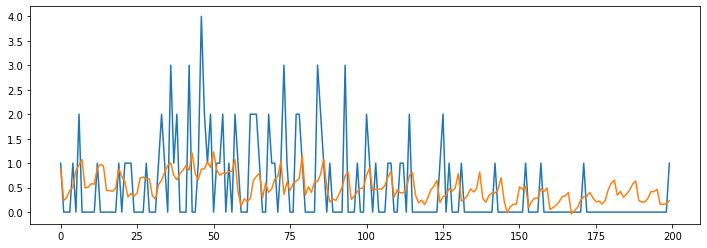

In [ ]:
#plt.plot(y_pred)
plt.plot(y_val2[:200])
plt.plot(y_pred[:200])

In [ ]:
sqrt(mean_squared_error(y_val2, y_pred_nn))

2.136739950406137

In [ ]:
y_pred.max()

5.079100297455092

<BarContainer object of 48 artists>

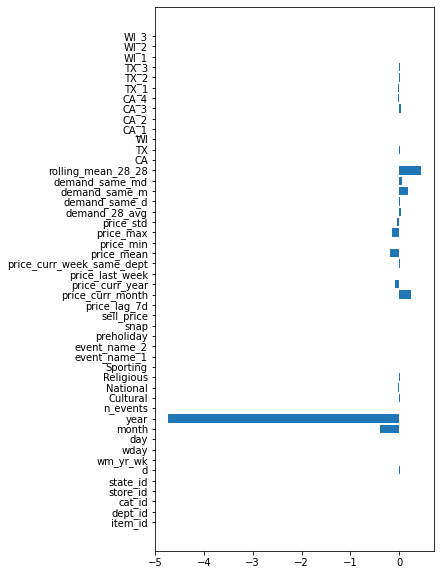

In [ ]:
plt.figure(figsize=(5,10))
plt.barh(x_cols, lr.coef_)

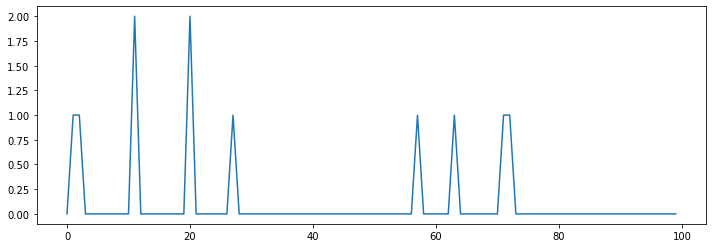

In [ ]:
plt.plot(y_val2[:100])

#### simple MLP

In [ ]:
from tensorflow.keras import layers, Model

In [ ]:
x_in = layers.Input(shape=len(x_cols))
x = layers.Dense(32, 'relu')(x_in)
x = layers.Dense(32, 'relu')(x)
x = layers.Dense(32, 'relu')(x)
#x = layers.Dense(8, 'relu')(x)
x_out= layers.Dense(1, 'linear')(x)

nn = Model(x_in, x_out)

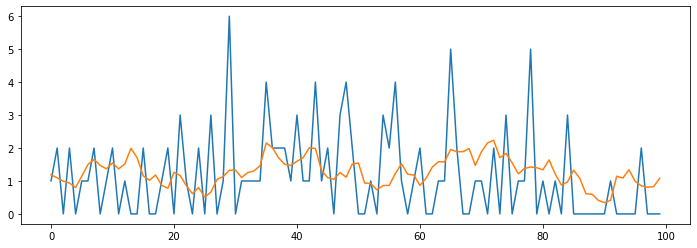

In [ ]:
plt.plot(y_val2[:100])
plt.plot(y_pred[:100])

In [ ]:
nn.compile('adam', 'mse', 'accuracy')

In [ ]:
nn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2)

Epoch 1/2
123761/123761 [==============================] - 200s 2ms/step - loss: 93.9162 - accuracy: 0.2289 - val_loss: 6.3987 - val_accuracy: 0.1934
Epoch 2/2
123761/123761 [==============================] - 195s 2ms/step - loss: 8.8635 - accuracy: 0.2220 - val_loss: 5.9899 - val_accuracy: 0.1934


In [ ]:
y_pred_nn = nn.predict(x_val)

In [ ]:
sqrt(mean_squared_error(y_val2, y_pred_nn))

1.9352142633298044

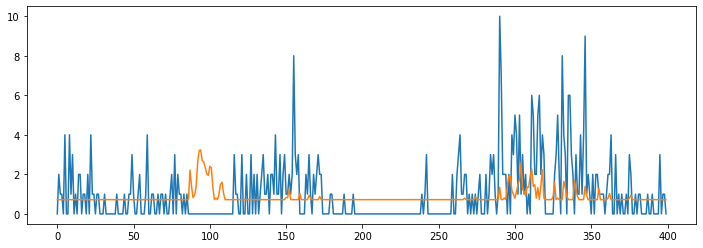

In [ ]:
plt.plot(y_val2[:400])
plt.plot(y_pred_nn[:400])

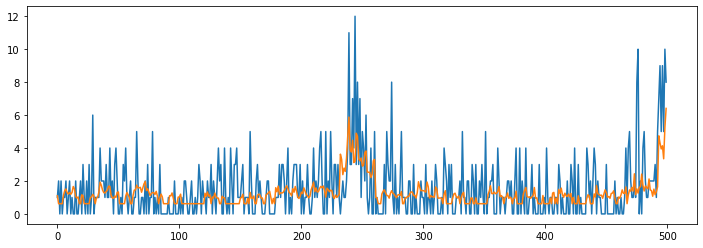

In [ ]:
plt.plot(y_val2[:500])
plt.plot(y_pred_nn[:500])

#### LGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(num_leaves=2**11-1, objective='regression', learning_rate=0.05 )

In [ ]:
lgbm.fit(x_train, y_train)

LGBMRegressor(learning_rate=0.05, num_leaves=2047, objective='regression')

In [ ]:
y_pred_lgbm = lgbm.predict(x_val)

In [ ]:
sqrt(mean_squared_error(y_val2, y_pred_lgbm))

1.90558466436661

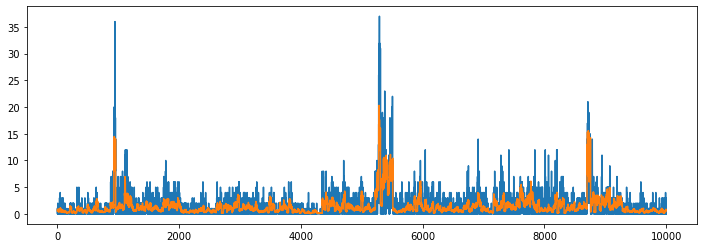

In [ ]:
plt.plot(y_val2[:10000])
plt.plot(y_pred_lgbm[:10000])